# PS4 
## MACS 30250, Dr. Evans
## Yiqing Zheng
## Problem 1 
(a)

In [5]:
import numpy as np

In [1]:
beta = 0.96**20 
delta = 1 - (1 - 0.05)**20 
sigma = 3
A = 1
alpha = 0.35

In [2]:
def get_K(b2t, b3t):
    return b2t + b3t

def get_Y(K, L, alpha, A):
    return A * (K ** alpha) * (L ** (1-alpha))

def get_r(K, L, alpha, A, delta):
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r

def get_w(K, L, alpha, A): 
    w = (1 - alpha) * A * ((K / L) ** alpha) 
    return w

def get_consumption(b, b1t, n, r, w):
    return w * n + (1 + r) * b - b1t

def get_util(consumption, sigma):
    return (consumption ** (1-sigma))/(1-sigma)

def get_MU(consumption, sigma):
    return consumption ** (-sigma)

In [3]:
def feasible(f_params, bvec_guess):
    nvec, A, alpha, delta = f_params
    b2t, b3t = bvec_guess
    K = get_K(b2t, b3t)
    L = nvec.sum()
    r = get_r(K, L, alpha, A, delta)
    w = get_w(K, L, alpha, A)
    c1 = get_consumption(0, b2t, nvec[0], r, w)
    c2 = get_consumption(b2t, b3t, nvec[1], r, w)
    c3 = get_consumption(b3t, 0, nvec[2], r, w)
    
    K_cnstr, c_cnstr, b_cnstr = np.full(1, False), np.full(3, False), np.full(2, False)
    
    c_cnstr[0] = c1 < 0 
    c_cnstr[1] = c2 < 0
    c_cnstr[2] = c3 < 0
    K_cnstr[0] = K < 0
    
    
    b_cnstr[0] = c_cnstr[0]==True
    
    if c_cnstr[1] == True:
        b_cnstr[0], b_cnstr[1] = True, True
    
    b_cnstr[1] = c_cnstr[2] == True
        
    return b_cnstr, c_cnstr, K_cnstr

In [6]:
nvec = np.array([1.0, 1.0, 0.2])
f_params = [nvec, A, alpha, delta]

In [7]:
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[ True False] [ True False False] [False]


(b)

In [8]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[False False] [False False False] [False]


(c)

In [9]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print(b_cnstr, c_cnstr, K_cnstr)

[False False] [False False False] [False]


## Problem 2

In [16]:
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [21]:
def Eulersys(bvec, args):
    
    nvec, A, alpha, delta, beta, sigma = args
    b2t, b3t = bvec
    
    L = nvec.sum()
    K = get_K(b2t, b3t)
    r = get_r(K, L, alpha, A, delta)
    w = get_w(K, L, alpha, A)
    c1 = get_consumption(0, b2t, nvec[0], r, w)
    c2 = get_consumption(b2t, b3t, nvec[1], r, w)
    c3 = get_consumption(b3t, 0, nvec[2], r, w)
    mu1 = get_MU(c1,sigma)
    mu2 = get_MU(c2,sigma)
    mu3 = get_MU(c3,sigma)
    
    # using simple differences
    Eul_err1 = mu1 - beta*(1+r) * mu2
    Eul_err2 = mu2 - beta*(1+r) * mu3
    Euler_err = np.array([Eul_err1, Eul_err2])
    
    return Euler_err

In [26]:
def get_SS(params, bvec_guess, SS_graphs = False):
    
    start_time = time.clock()
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    args = np.array([nvec, A, alpha, delta, beta, sigma])
    results_bss = opt.root(Eulersys, bvec_guess, 
                           tol=SS_tol, args = args)
    b_ss =  results_bss.x
    
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(K_ss, L, alpha, A, delta)
    Y_ss = get_Y(K_ss, L, alpha, A)
    w_ss = get_w(K_ss, L, alpha, A)
    c1 = get_consumption(0, b2, nvec[0], r_ss, w_ss)
    c2 = get_consumption(b2, b3, nvec[1], r_ss, w_ss)
    c3 = get_consumption(b3, 0, nvec[2], r_ss, w_ss)
    c_ss = np.array([c1, c2, c3])
    C_ss = c_ss.sum()
    EulErr_ss = Eulersys(b_ss, args)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock() - start_time
    
    ss_output = {
    'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    
    if SS_graphs:
        x = np.array([1,2,3])
        plt.plot(x, c_ss, marker='o',label="steady state consumptions")
        y = np.array([1,2])
        plt.plot(y, b_ss, marker='o',label="steady state savings")
        plt.title('Steady-state distribution')
        plt.legend()
        plt.show()
    return ss_output

(a)

In [27]:
SS_tol = 1e-10
params = [beta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
get_SS(params, bvec_guess)

C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([-1.33582034e-12,  2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0010457999960635789}

It takes 0.0014s to get the steady state.

(b)

C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


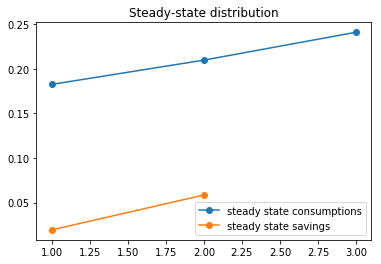

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([-1.33582034e-12,  2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.0006198000046424568}

In [28]:
get_SS(params, bvec_guess,SS_graphs = True)

(c)

In [29]:
params2 = [0.55, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol]
get_SS(params2, bvec_guess)

C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003315,
 'r_ss': 1.8863599991452351,
 'K_ss': 0.10504252550764615,
 'Y_ss': 0.7586693633878046,
 'C_ss': 0.6912831045288896,
 'EulErr_ss': array([-2.84217094e-14, -2.84217094e-14]),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0005281000048853457}

For every period, consumption, saving, and wage increase, but interest rate decreases.The intuition is that when $\beta$ increases, people vaule future consumption more. So they save more. Inerest rate can be viewed as the price of capital. As the savings increase, there exist more supply of capital, so interest rate decreases. Because capital increases, the wage increases. People consumes more because income effect is large enough.

## Problem 3

In [48]:
import scipy.linalg as la

In [32]:
xi = 0.2
tol = 1e-9
eul_tol = 1e-6 
maxiter_TPI = 10000
L = 2.2
T = 20
params3 = [beta, sigma, nvec, L, A, alpha, delta, eul_tol]

In [34]:
b_ss = get_SS(params, bvec_guess)['b_ss']
b2bar,b3bar = b_ss[0],b_ss[1]
b_ss = np.array(b_ss)

b21 = 0.8 * b2bar
b31 = 1.1 * b3bar
bvec_guess = np.array([b21, b31])

K1 = b21 + b31
Kbar = b2bar + b3bar
Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, Kbar)

C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nanka\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [35]:
def get_path(T, Kpath, Kbar, params):
    
    rpath = np.zeros(T)
    wpath = np.zeros(T)
    for t in range(T):
        rpath[t] = get_r(Kpath[t], L, alpha, A, delta)
        wpath[t] = get_w(Kpath[t], L, alpha, A)
    rbar = get_r(Kbar, L, alpha, A, delta)
    wbar = get_w(Kbar, L, alpha, A)
    rpath = np.append(rpath, rbar)
    wpath = np.append(wpath, wbar)
    
    return np.array([rpath, wpath])

In [36]:
def Eulersys2(b32, b32_params):
    
    b21,b22,rpath,wpath,params = b32_params[0],b32_params[1],b32_params[2],b32_params[3],b32_params[4]
    c1 = get_consumption(b21, b32, params[2][1], rpath[0], wpath[0])
    u1 = get_MU(c1, sigma)
    c2 = get_consumption(b32, 0, params[2][2], rpath[1], wpath[1])
    u2 = get_MU(c2, sigma)
    
    return u1 - params[0] * (1 + rpath[1]) * u2

In [37]:
def get_b32(b21, b22, rpath, wpath, params, bvec_guess):
    
    b32_params = [b21, b22, rpath, wpath, params]
    result = opt.root(Eulersys2,bvec_guess[0],args = b32_params, tol = params[7])
    b32 = result.x
    b32_EulErrs = result.fun
    
    return np.array([b32, b32_EulErrs])

def get_consumption(b, b1, n, r, w):
    return w * n + (1 + r) * b - b1

In [40]:
def get_b_EulErr(b, b_params):
    
    t, rpath, wpath, params = b_params[0],b_params[1],b_params[2],b_params[3]
    
    c21 = get_consumption(0,  b[0], params[2][0], 0, wpath[t])
    u21 = get_MU(c21, sigma)
    c22 = get_consumption(b[0], b[1], params[2][1], rpath[t+1], wpath[t+1])
    u22 = get_MU(c22, sigma)
    b2_EulErr = u21 - params[0] * (1 + rpath[t+1]) * u22
    
    c31 = get_consumption(b[0], b[1], params[2][1], rpath[t+1], wpath[t+1])
    u31 = get_MU(c31, sigma)
    c32 = get_consumption(b[1], 0, params[2][2], rpath[t+2], wpath[t+2])
    u32 = get_MU(c32, sigma)
    b3_EulErrs = u31 - params[0] * (1 + rpath[t+2]) * u32
    
    return np.array([b2_EulErr, b3_EulErrs])

In [41]:
def get_b(t, rpath, wpath, params, bvec_guess):
    
    b_params = [t, rpath, wpath, params]
    result = opt.root(get_b_EulErr, bvec_guess, args = b_params, tol = params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])

In [42]:
def get_errs(Kpath, rpath, wpath, bmat, params):
    
    L = params[2].sum()
    C = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
    Y = params[4] * (Kpath[:-1]**params[5]) * L**(1 - params[5])
    agg_err = Y - C - Kpath[1:] + (1 - params[6]) * Kpath[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err

In [43]:
def get_result(T, rpath, wpath, Kpath, bvec_guess, b_ss, params):
    
    bmat = np.zeros((T+1, 2))
    bmat[0,:] = bvec_guess
    EulErrs = np.zeros((T+1, 2))
    cols = [0,1]
    for t in range(T-1):
        rows = [t+1, t+2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, rpath, wpath,params,bvec_guess)
    bmat[1,1], EulErrs[1,1] = get_b32(bmat[0,0], bmat[0,1], rpath, wpath, params, bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis = 0)
    agg_errs = get_errs(Kpath, rpath, wpath, bmat, params)
    
    return bmat, max_EulErrs, agg_errs

In [44]:
def Kprime(bmat, Kbar):
    
    Kp_path = bmat[:-1,:].sum(axis = 1)
    Kp_path = np.append(Kp_path, Kbar)
    
    return Kp_path

In [45]:
def TPI(T, Kpath, Kbar, bvec_guess, b_ss, params, tol, max_iter):
    
    dist = 1e9
    i = 0
    
    while (dist > tol) & (i < max_iter):
        i += 1
        rpath, wpath = get_path(T, Kpath, Kbar, params)
        bmat, max_EulErrs, max_agg_errs = get_result(T, rpath, wpath, Kpath, bvec_guess, b_ss, params)
        Kp_path = Kprime(bmat, Kbar)
        dist = la.norm(Kp_path - Kpath, 2)
        Kpath = xi * Kp_path + (1 - xi) * Kpath
    
    print('Max absolute Euler errors: ', (max_EulErrs[0],max_EulErrs[1]))
    print('Max absolute aggregate resources constraint error:', max_agg_errs)
    
    return Kpath, rpath, wpath

(a)

In [49]:
K, r, w = TPI(T, Kpath, Kbar, bvec_guess, b_ss, params3, tol, maxiter_TPI)

Max absolute Euler errors:  (3.2134150274032436e-07, 9.464251604640594e-08)
Max absolute aggregate resources constraint error: 0.019312759519526327


(b)

Text(0, 0.5, 'K')

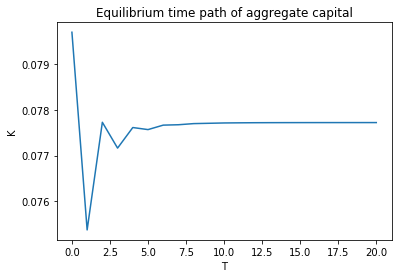

In [50]:
plt.plot(K)
plt.title('Equilibrium time path of aggregate capital')
plt.xlabel('T')
plt.ylabel('K')

Text(0, 0.5, 'r')

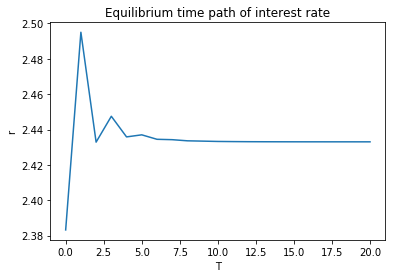

In [51]:
plt.plot(r)
plt.title('Equilibrium time path of interest rate')
plt.xlabel('T')
plt.ylabel('r')

Text(0, 0.5, 'w')

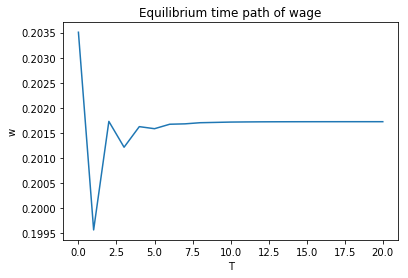

In [52]:
plt.plot(w)
plt.title('Equilibrium time path of wage')
plt.xlabel('T')
plt.ylabel('w')

(c)

In [53]:
K_dist = np.abs(K - Kbar)
err = 1e-5
pos1 = np.where(K_dist < err)[0]
pos2 = np.ediff1d(pos1) == 1

In [54]:
print('Number of periods taken by the economy to get within 0.00001 of the steady state aggregate capital: ', pos1.min())
print('Number of periods from which the economy stays within 0.00001 of the steady state aggregate capital: ', pos1[-len(pos2)])

Number of periods taken by the economy to get within 0.00001 of the steady state aggregate capital:  2
Number of periods from which the economy stays within 0.00001 of the steady state aggregate capital:  10
